In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import itertools
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib import colors
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from sklearn.decomposition import PCA
from sklearn import manifold
import sys
import torch
from tqdm.auto import tqdm

plt.style.use('/om2/user/eisenaj/code/ChaoticConsciousness/sci_style.py')

sys.path.append('..')
from data_utils import get_data_class, load_session_data, load_window_from_chunks, combine_grid_results

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from delase import *
from dmd import embed_signal_torch
from utils import numpy_torch_conversion

In [3]:
os.system('echo host:\nhostname')
print(f"cuda: {torch.cuda.is_available()}")
print(f"{torch.from_numpy(np.random.randn(4)).to('cuda').cpu().numpy()}")

host:
node078
cuda: True
[-1.61392264 -1.2796388   2.26125815  1.26206811]


In [4]:
def get_section(t, section_times):
    for section, bounds in section_times.items():
        if t >= bounds[0] and t < bounds[1]:
            return section

def intersection(a, b):
    return [x for x in a if x in b]

def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [5]:
session = 'MrJones-Anesthesia-20160125-01'
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
variables = ['electrodeInfo', 'sessionInfo', 'trialInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, session_info, trial_info = session_vars['electrodeInfo'], session_vars['sessionInfo'], session_vars['trialInfo']

In [6]:
section_colors = {
    'late_anesthesia': 'plum',
    'anesthesia': 'darkorchid',
    'wake': 'limegreen',
}

In [7]:
save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/dimensionality_reduction/trial_responses'
leadin = 2
response_length = 2
leadout = 3

# Delay Embed and Do PCA

In [9]:
all_delay_embeddings_avg = {}
all_pca_responses = {}
for n_delays, delay_interval in [(1, 1), (2, 1), (2, 10), (2, 20), (5, 20), (10, 20), (16, 20), (32, 20)]:
# for n_delays, delay_interval in [(n_delays, delay_interval)]:
    print("-"*60)
    print(f"n_delays: {n_delays}, delay_interval: {delay_interval}")
    save_path = os.path.join(save_dir, f"all_delay_embedding_{leadin}_{response_length}_{leadout}_{n_delays}_{delay_interval}.pkl")
    
    all_delay_embeddings_avg[(n_delays, delay_interval)] = {}
    all_pca_responses[(n_delays, delay_interval)] = {}
    
    if not os.path.exists(save_path):

        batch_size = 25
        num_total_trials = np.sum([np.sum([np.sum([trial_responses[section][trial_type].shape[0] for trial_type in trial_responses[section].keys()]) for section in trial_responses.keys()]) for trial_responses in [all_trial_responses[name]['trial_responses'] for name in all_trial_responses.keys()]])
        iterator = tqdm(total=num_total_trials, desc="Delay Embedding")

        
        for name in all_trial_responses.keys():
            trial_responses = all_trial_responses[name]['trial_responses']

            delay_embeddings_avg = {}
            
            for section in trial_responses.keys():
                delay_embeddings_avg[section] = {}
                for trial_type in trial_responses[section].keys():
                    delay_embeddings_avg[section][trial_type] = None
                    num_batches = int(np.ceil(trial_responses[section][trial_type].shape[0]/batch_size))
                    # for trial_num in range(trial_responses[section][trial_type].shape[0]):
                    for batch_num in range(num_batches):
                        batch_start = batch_num*batch_size
                        batch_end = np.min([(batch_num + 1)*batch_size, trial_responses[section][trial_type].shape[0]])
                        with torch.no_grad():
                            x = torch.from_numpy(trial_responses[section][trial_type][batch_start:batch_end]).to('cuda')
                            delay_embed = embed_signal_torch(x, n_delays, delay_interval)
                            delay_embed = delay_embed.sum(axis=0).cpu().numpy()
                            if delay_embeddings_avg[section][trial_type] is None:
                                delay_embeddings_avg[section][trial_type] = delay_embed
                            else:
                                delay_embeddings_avg[section][trial_type] += delay_embed

                        iterator.update(batch_end - batch_start)
                
                    delay_embeddings_avg[section][trial_type] /= trial_responses[section][trial_type].shape[0]
            
            all_delay_embeddings_avg[(n_delays, delay_interval)][name] = delay_embeddings_avg

        iterator.close()

        pd.to_pickle(all_delay_embeddings_avg, save_path)
    else:
        print("loading delay embeddings from file")
        all_delay_embeddings_avg[(n_delays, delay_interval)] = pd.read_pickle(save_path)

    save_path = os.path.join(save_dir, f"all_pca_responses_{leadin}_{response_length}_{leadout}_{n_delays}_{delay_interval}.pkl")
    if not os.path.exists(save_path):
        all_pca_its = np.sum([len(delay_embeddings_avg.keys())*len(trial_responses[list(delay_embeddings_avg.keys())[0]].keys()) for delay_embeddings_avg in all_delay_embeddings_avg.values()])
        iterator = tqdm(total=all_pca_its, desc="PCA")

        
        for name in all_trial_responses.keys():
            trial_responses = all_trial_responses[name]['trial_responses']
            delay_embeddings_avg = all_delay_embeddings_avg[name]
            pca_responses = {}
            
            for section in delay_embeddings_avg.keys():
                for trial_type in delay_embeddings_avg[section].keys():
                    if section not in pca_responses.keys():
                        pca_responses[section] = {}

                    pca_responses[section][trial_type] = {}
                    delay_embed = delay_embeddings_avg[section][trial_type]
                    pca = PCA(n_components=3)
                    pca_responses[section][trial_type]['embed'] = pca.fit_transform(delay_embed)
                    pca_responses[section][trial_type]['explained_variance_ratio'] = pca.explained_variance_ratio_
                    # print(f"{section} {trial_type}: {pca.explained_variance_ratio_}")

                    iterator.update()

            all_pca_responses[(n_delays, delay_interval)][name] = pca_responses
        iterator.close()
        pd.to_pickle(all_pca_responses, save_path)
    else:
        print("loading pca responses from file")
        all_pca_responses[(n_delays, delay_interval)] = pd.read_pickle(save_path)

------------------------------------------------------------
n_delays: 1, delay_interval: 1
loading delay embeddings from file
loading pca responses from file
------------------------------------------------------------
n_delays: 2, delay_interval: 1
loading delay embeddings from file
loading pca responses from file
------------------------------------------------------------
n_delays: 2, delay_interval: 10
loading delay embeddings from file
loading pca responses from file
------------------------------------------------------------
n_delays: 2, delay_interval: 20
loading delay embeddings from file
loading pca responses from file
------------------------------------------------------------
n_delays: 5, delay_interval: 20
loading delay embeddings from file
loading pca responses from file
------------------------------------------------------------
n_delays: 10, delay_interval: 20
loading delay embeddings from file
loading pca responses from file
-----------------------------------------

# Plot

In [23]:
dt = 0.001
trial_type = 'tonePuff'

In [15]:
params = list(all_pca_responses.keys())
names = list(all_pca_responses[params[0]].keys())
sections = list(all_pca_responses[params[0]][names[0]].keys())
trial_types = list(all_pca_responses[params[0]][names[0]][sections[0]].keys())

In [17]:
param_combo = params[0]

In [34]:
param_combo = (32, 20)

In [35]:
n_timepts = all_pca_responses[param_combo][names[0]][sections[0]][trial_types[0]]['embed'].shape[0]
color_list = {
    'toneOnly': plt.cm.get_cmap('RdYlBu_r')(np.linspace(0, 1, n_timepts)),
    'puffOnly': plt.cm.get_cmap('RdYlBu_r')(np.linspace(0, 1, n_timepts)),
    'tonePuff': plt.cm.get_cmap('RdYlBu_r')(np.linspace(0, 1, n_timepts))
}

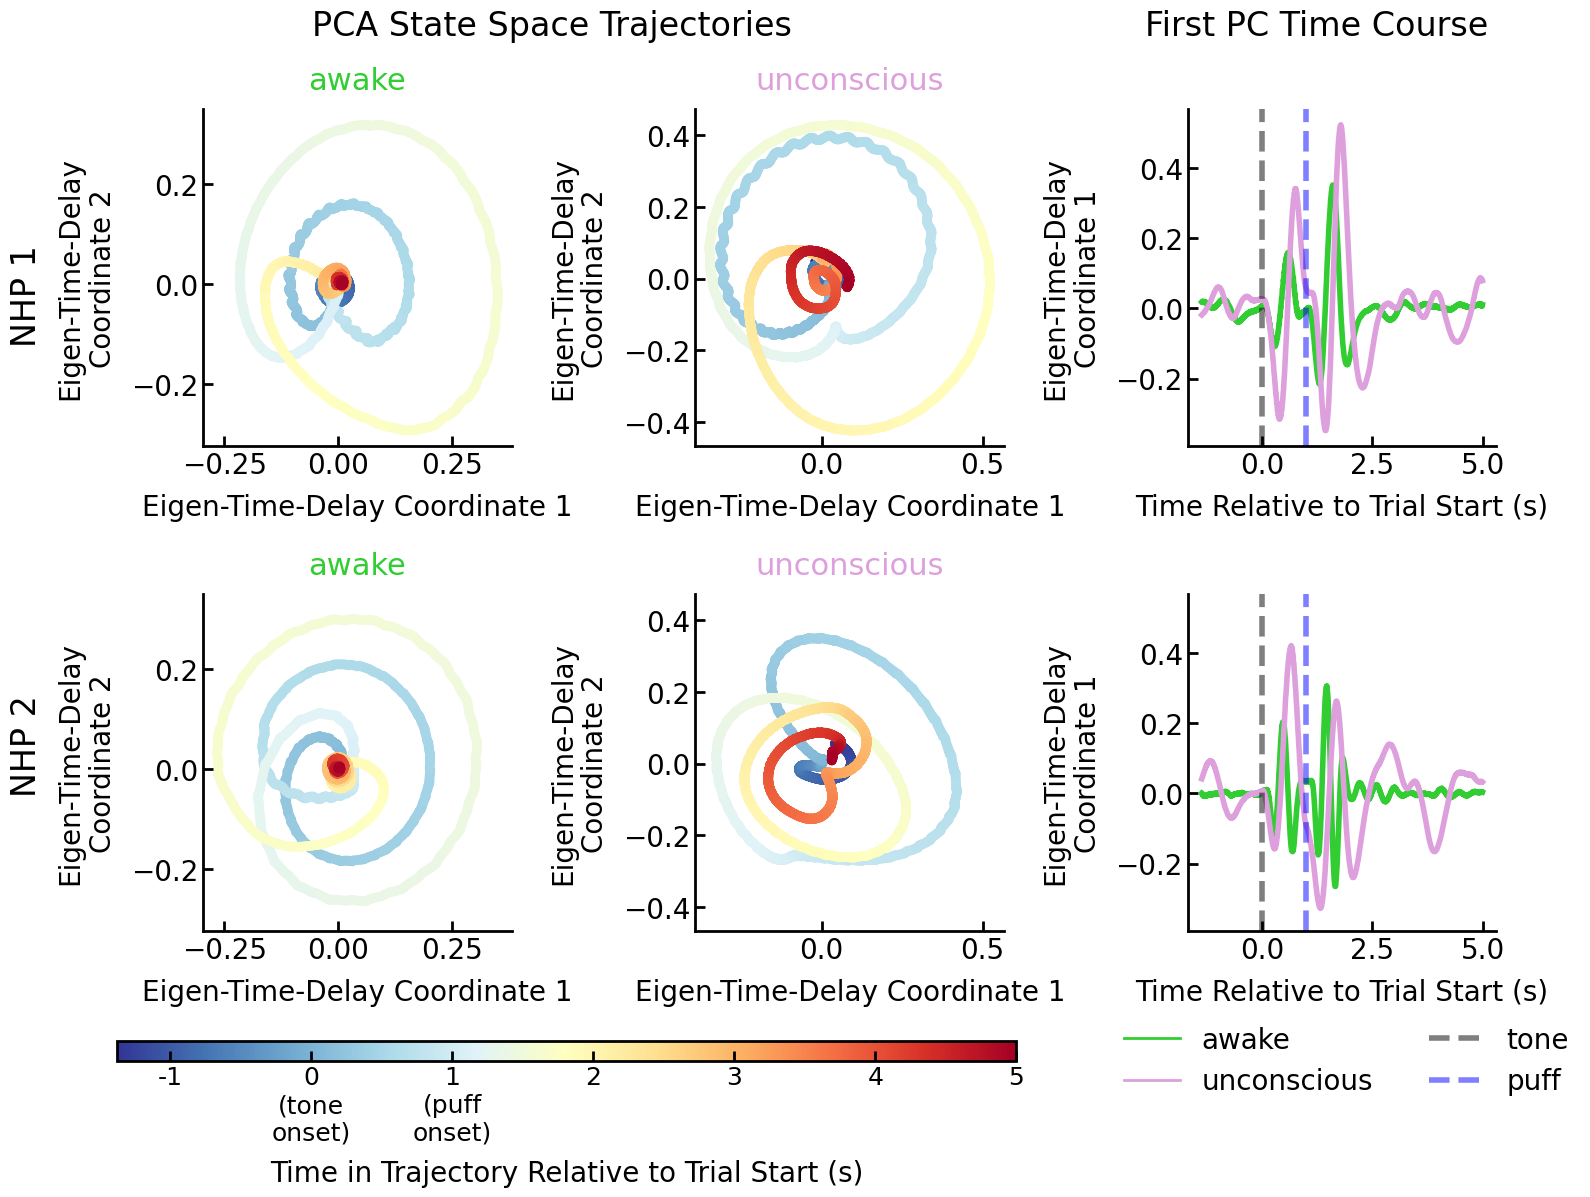

In [36]:
# gap = (int((response_length + leadin + leadout)/dt) - n_timepts)/2
gap = (int((response_length + leadin + leadout)/dt) - n_timepts)
# gap = 0

# subplot_title_fontsize = 16
# xlabel_fontsize = 16
# ylabel_fontsize = 16
# xticklab

sections_to_plot = ['wake', 'late_anesthesia']

trial_type_labels = {
    'puffOnly': 'puff only',
    'toneOnly': 'tone only',
    'tonePuff': 'tone-puff'
}

fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex='col', sharey='col')

# cmap = plt.cm.get_cmap('RdYlBu_r')
# color_list = cmap(np.linspace(0, 1, int(response_length/dt) + int((leadin + leadout)/dt))[:delay_embed.shape[1]])
for i, name in enumerate(names):
    pca_responses = all_pca_responses[param_combo][name]
    for j in range(3):
        ax = axs[i][j]
        if j == 2:
            trial_type = 'tonePuff'
            for section in sections_to_plot:
                time_vals = (np.arange(pca_responses[section][trial_type]['embed'].shape[0]) + gap)*dt - leadin
                ax.plot(time_vals, pca_responses[section][trial_type]['embed'][:, 0], label='section', c=section_colors[section], lw=4)
                # ax.scatter(time_vals, pca_responses[section][trial_type]['embed'][:, 1])
           
                

            if trial_type == 'puffOnly' or trial_type == 'tonePuff':
                ax.axvline(1, color='blue', linestyle='--', alpha=0.5, lw=4)
            if trial_type == 'toneOnly' or trial_type == 'tonePuff':
                ax.axvline(0, color='k', linestyle='--', alpha=0.5, lw=4)
            # if i == 0:
                # ax.set_title(f"First PC Timecourse", fontsize=24)
            
            # {trial_type_labels[trial_type]}

            ax.set_xlabel('Time Relative to Trial Start (s)')
            ax.set_ylabel('Eigen-Time-Delay\nCoordinate 1')
        
        if j < 2:
            section = sections_to_plot[j]
            time_vals = (np.arange(pca_responses[section]['tonePuff']['embed'].shape[0]) + gap)*dt - leadin
            ax.scatter(pca_responses[section]['tonePuff']['embed'][:, 0], pca_responses[section][trial_type]['embed'][:, 1], c=color_list[trial_type])

            ax.set_xlabel('Eigen-Time-Delay Coordinate 1')
            ax.set_ylabel('Eigen-Time-Delay\nCoordinate 2')

            if j == 0:
                ax.set_title("awake", c='limegreen', fontsize=22)
            if j == 1:
                ax.set_title("unconscious", c='plum', fontsize=22)
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

lns = []
lns += plt.plot([], color='limegreen', label='awake')
lns += plt.plot([], color='plum', label='unconscious')
lns += plt.plot([], color='k', linestyle='--', alpha=0.5, label='tone', lw=4)
lns += plt.plot([], color='blue', linestyle='--', alpha=0.5, label='puff', lw=4)
# fig.legend(lns, [ln.get_label() for ln in lns], loc='center', ncol=2, bbox_to_anchor=(0.22, -0.025))
fig.legend(lns, [ln.get_label() for ln in lns], loc='center', ncol=2, bbox_to_anchor=(0.88, -0.025))

fig.text(0, 0.74, 'NHP 1', ha='center', va='center', fontsize=24, rotation='vertical')
fig.text(0, 0.29, 'NHP 2', ha='center', va='center', fontsize=24, rotation='vertical')

# fig.text(0.23, 1.01, 'First PC Timecourse', ha='center', va='center', fontsize=24)
# fig.text(0.68, 1.01, 'PCA State Space Trajectories', ha='center', va='center', fontsize=24)

fig.text(0.86, 1.01, 'First PC Time Course', ha='center', va='center', fontsize=24)
fig.text(0.35, 1.01, 'PCA State Space Trajectories', ha='center', va='center', fontsize=24)


plt.tight_layout()

cbar_tick_labels = np.arange(10)
cbar_tick_labels = cbar_tick_labels[cbar_tick_labels <= (leadin + response_length + leadout)]
cbar_tick_labels = cbar_tick_labels[cbar_tick_labels >= gap*dt]
cbar_ticks = cbar_tick_labels/dt - gap
cbar_tick_labels -= leadin
start_ind = np.where(cbar_tick_labels == 0)[0][0]
cbar_tick_labels = list(cbar_tick_labels)
# cbar_tick_labels[]
cbar_tick_labels[start_ind] = f"{cbar_tick_labels[start_ind]:d}\n(tone\nonset)"
cbar_tick_labels[start_ind + 1] = f"{cbar_tick_labels[start_ind + 1]:d}\n(puff\nonset)"


sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('RdYlBu_r'), norm=plt.Normalize(vmin=0, vmax=1))
cbar_ax = fig.add_axes([0.06, -0.025, 0.6, 0.02])
cbar = fig.colorbar(sm, orientation='horizontal', cax=cbar_ax)
cbar.set_ticks(cbar_ticks/n_timepts)
cbar.set_ticklabels(cbar_tick_labels, fontsize=18)
cbar.set_label('Time in Trajectory Relative to Trial Start (s)')

plt.show()